# Sparse subframes

Here we modify objective function to add an L1 penalty to the gains, thereby achieving a sparse gain vector.


June 2022

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial

import frame_whitening as fw
from frame_whitening.types import *
import frame_whitening.simulation as fwsim

In [2]:
np.random.seed(420)

Q = fw.rot2(np.deg2rad(45))
kappa = 8
Cxx0 = Q @ np.diag([kappa, 1]) @ Q.T * 1 / (np.sqrt(kappa))

cholesky_list = [np.linalg.cholesky(C) for C in [Cxx0]]
N, K = 2, 6
W = np.random.randn(N, K)
W = fw.normalize_frame(W)
print("Frame dims:", W.shape, " (more than necessary)")

Frame dims: (2, 6)  (more than necessary)


## Run Simulation

In [3]:
batch_size = 1024
n_batch = 5000
lr_g = 1e-2
beta = 0.05

func_type, alpha = FuncType.G_EXPONENTIAL, None  # alpha must be None if not POWER
get_y, get_dg = fwsim.get_opt_funcs(func_type) 

if func_type == FuncType.POWER:
    get_y = partial(get_y, alpha=alpha)
    get_dg = partial(get_dg, alpha=alpha, beta=beta)
else:
    get_y = partial(get_y)
    get_dg = partial(get_dg, beta=beta)

g0 = fwsim.init_g_const(0.1, K, func_type, alpha=alpha)

g_last, g_all, errors = fwsim.simulate(
    cholesky_list,
    W,
    get_y,
    get_dg,
    batch_size,
    n_batch,
    lr_g,
    g0=g0,
)

## Plot

### Error convergence

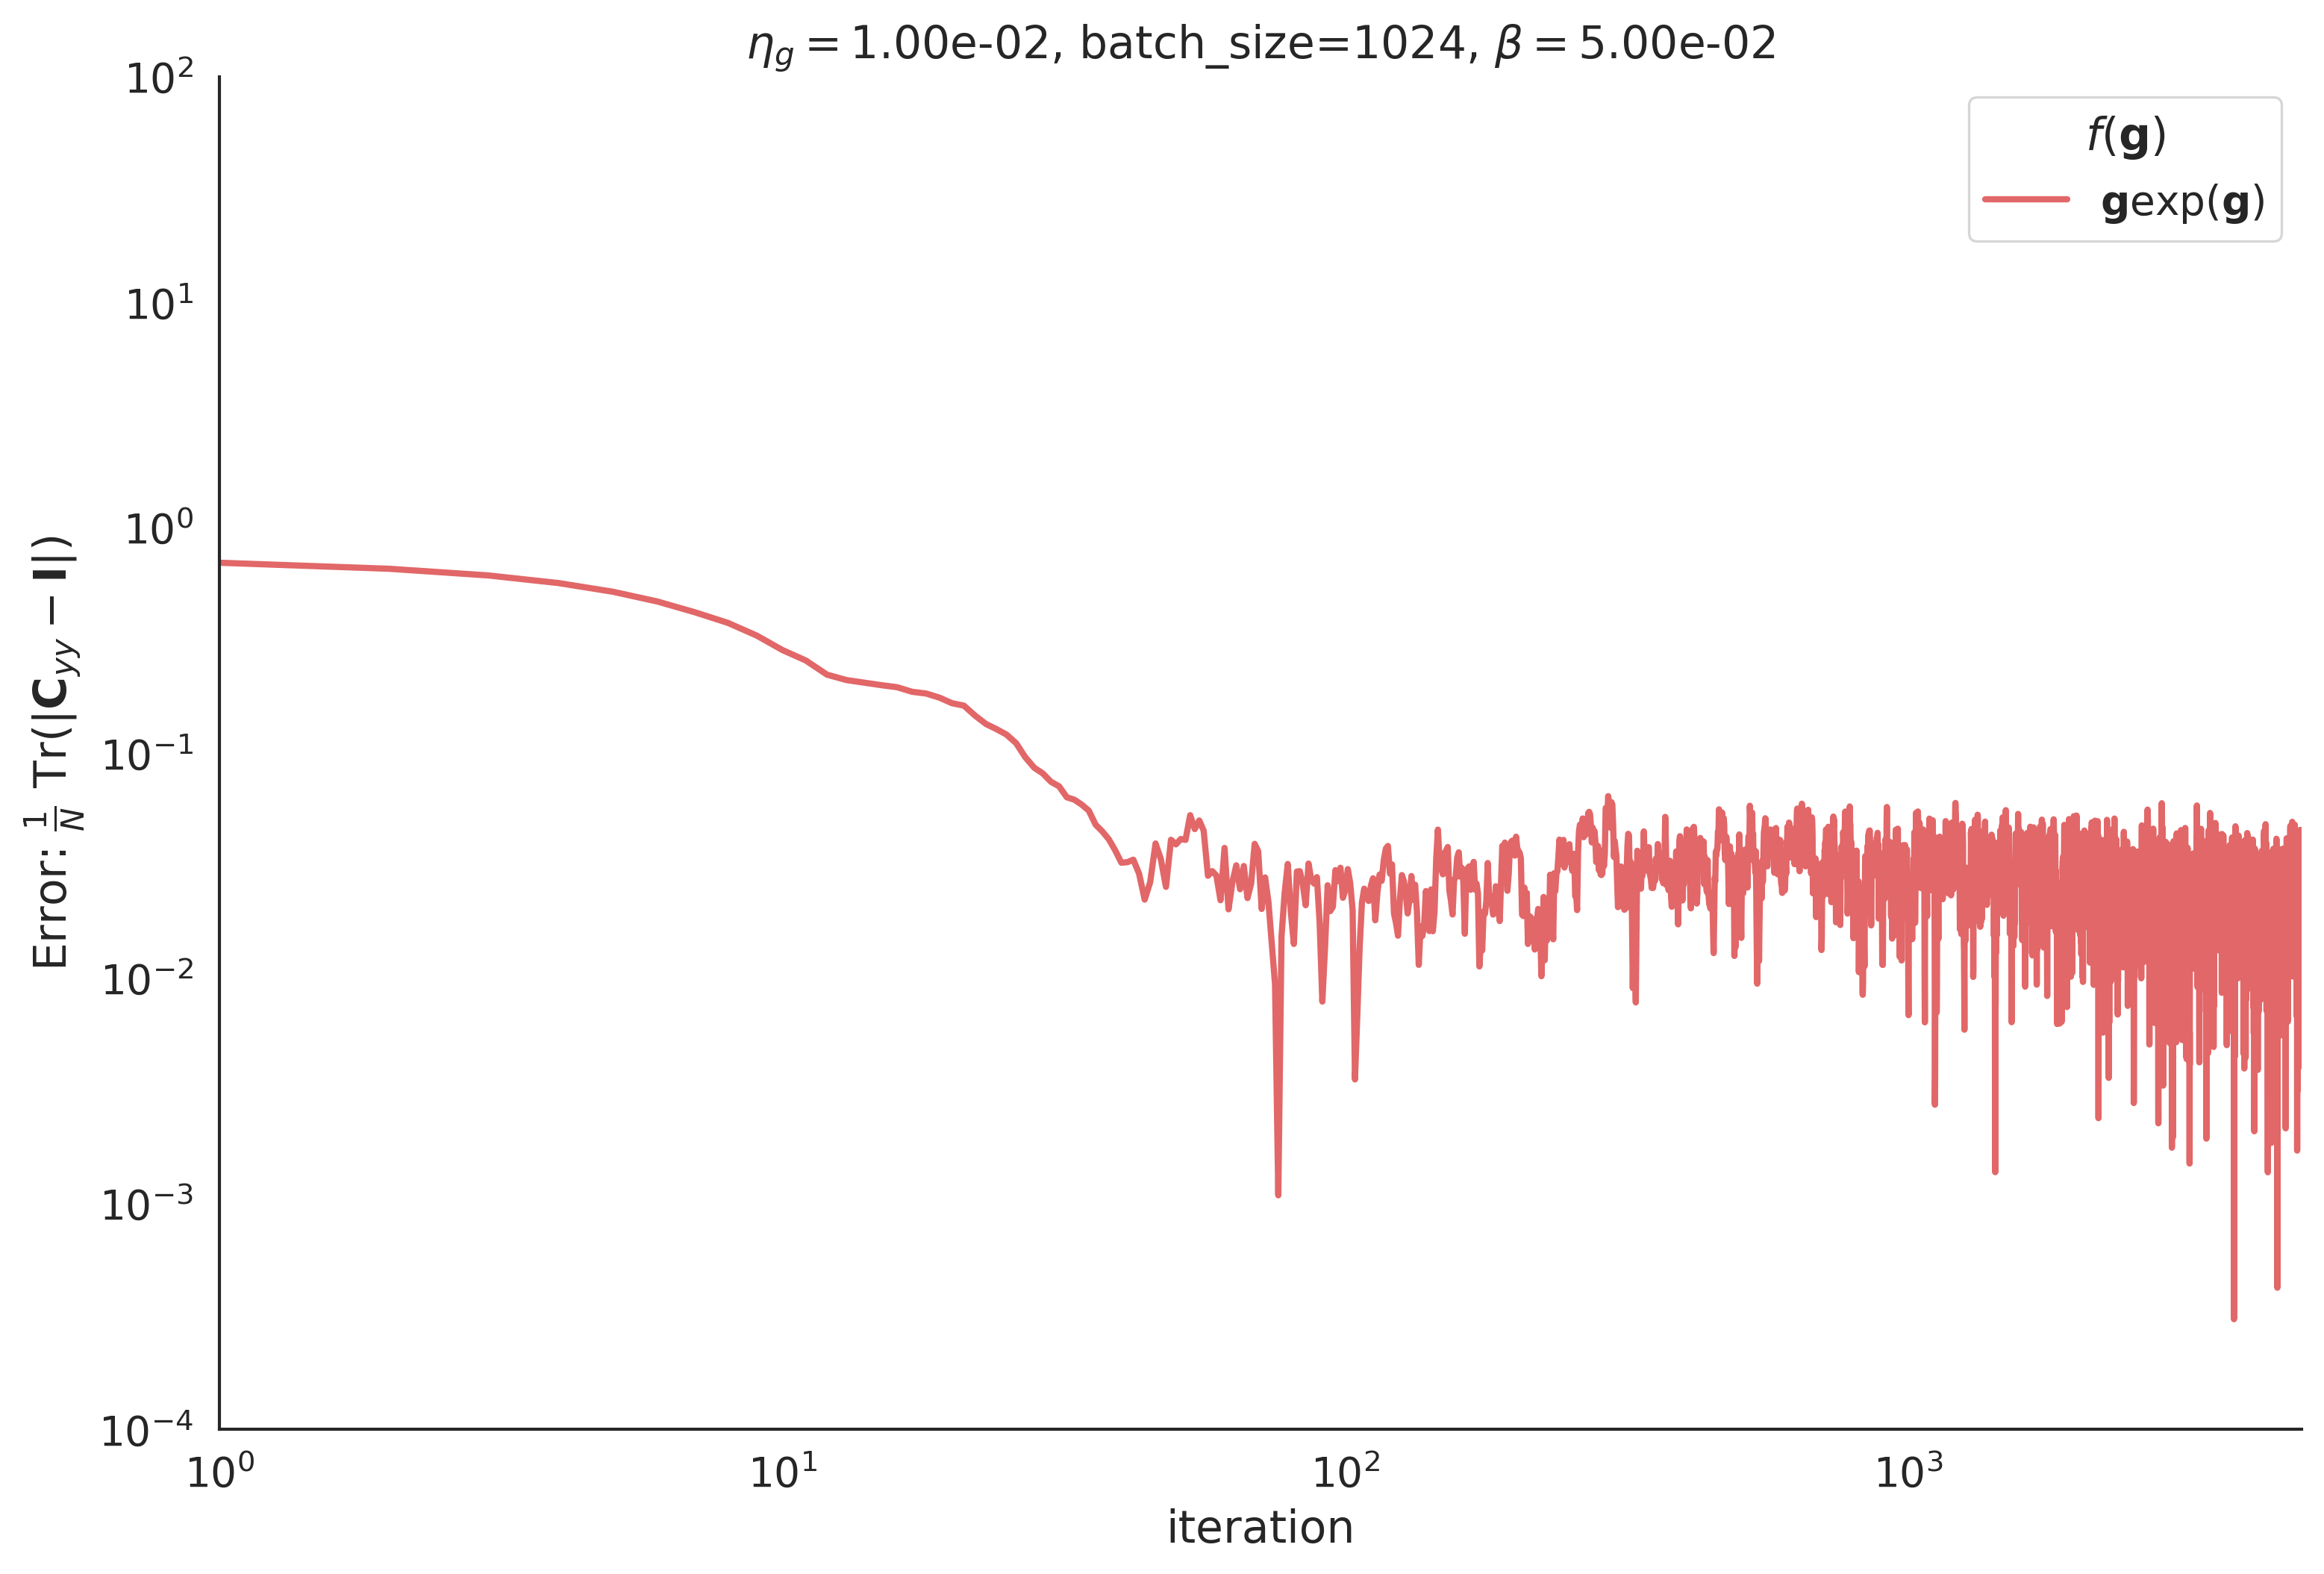

In [4]:
if func_type == FuncType.G_EXPONENTIAL:
    func_label = r"${\bf g}\exp({\bf g})$"
elif func_type == FuncType.EXPONENTIAL:
    func_label = r"$\exp({\bf g})$"
elif func_type == FuncType.POWER:
    func_label = r"${\bf g}"+("^{:d}$".format(alpha + 1))

with sns.plotting_context("paper", font_scale=1.5):
    sns.set_style("white")
    fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=300)
    N, K = W.shape

    label = r"${\bf g}\exp({\bf g})$"
    ax.plot(errors, color="C3", label=label, linewidth=2, alpha=0.7)

    ax.set(
        yscale="log",
        xscale="log",
        ylim=(1e-4, 1e2),
        xlim=(1, n_batch),
        xlabel="iteration",
        ylabel=r"Error: $\frac{1}{N}$ Tr($\vert {\bf C}_{yy} - {\bf I} \vert$)",
        title=f"$\eta_g=${lr_g:.2e}, batch_size={batch_size}, $\\beta=${beta:.2e}",
    )
    ax.legend(title=r"$f({\bf g})$")
    sns.despine()

### Gains over time

Only 3 of the 6 possible frame vectors are needed to whiten, so the rest are set to zero.

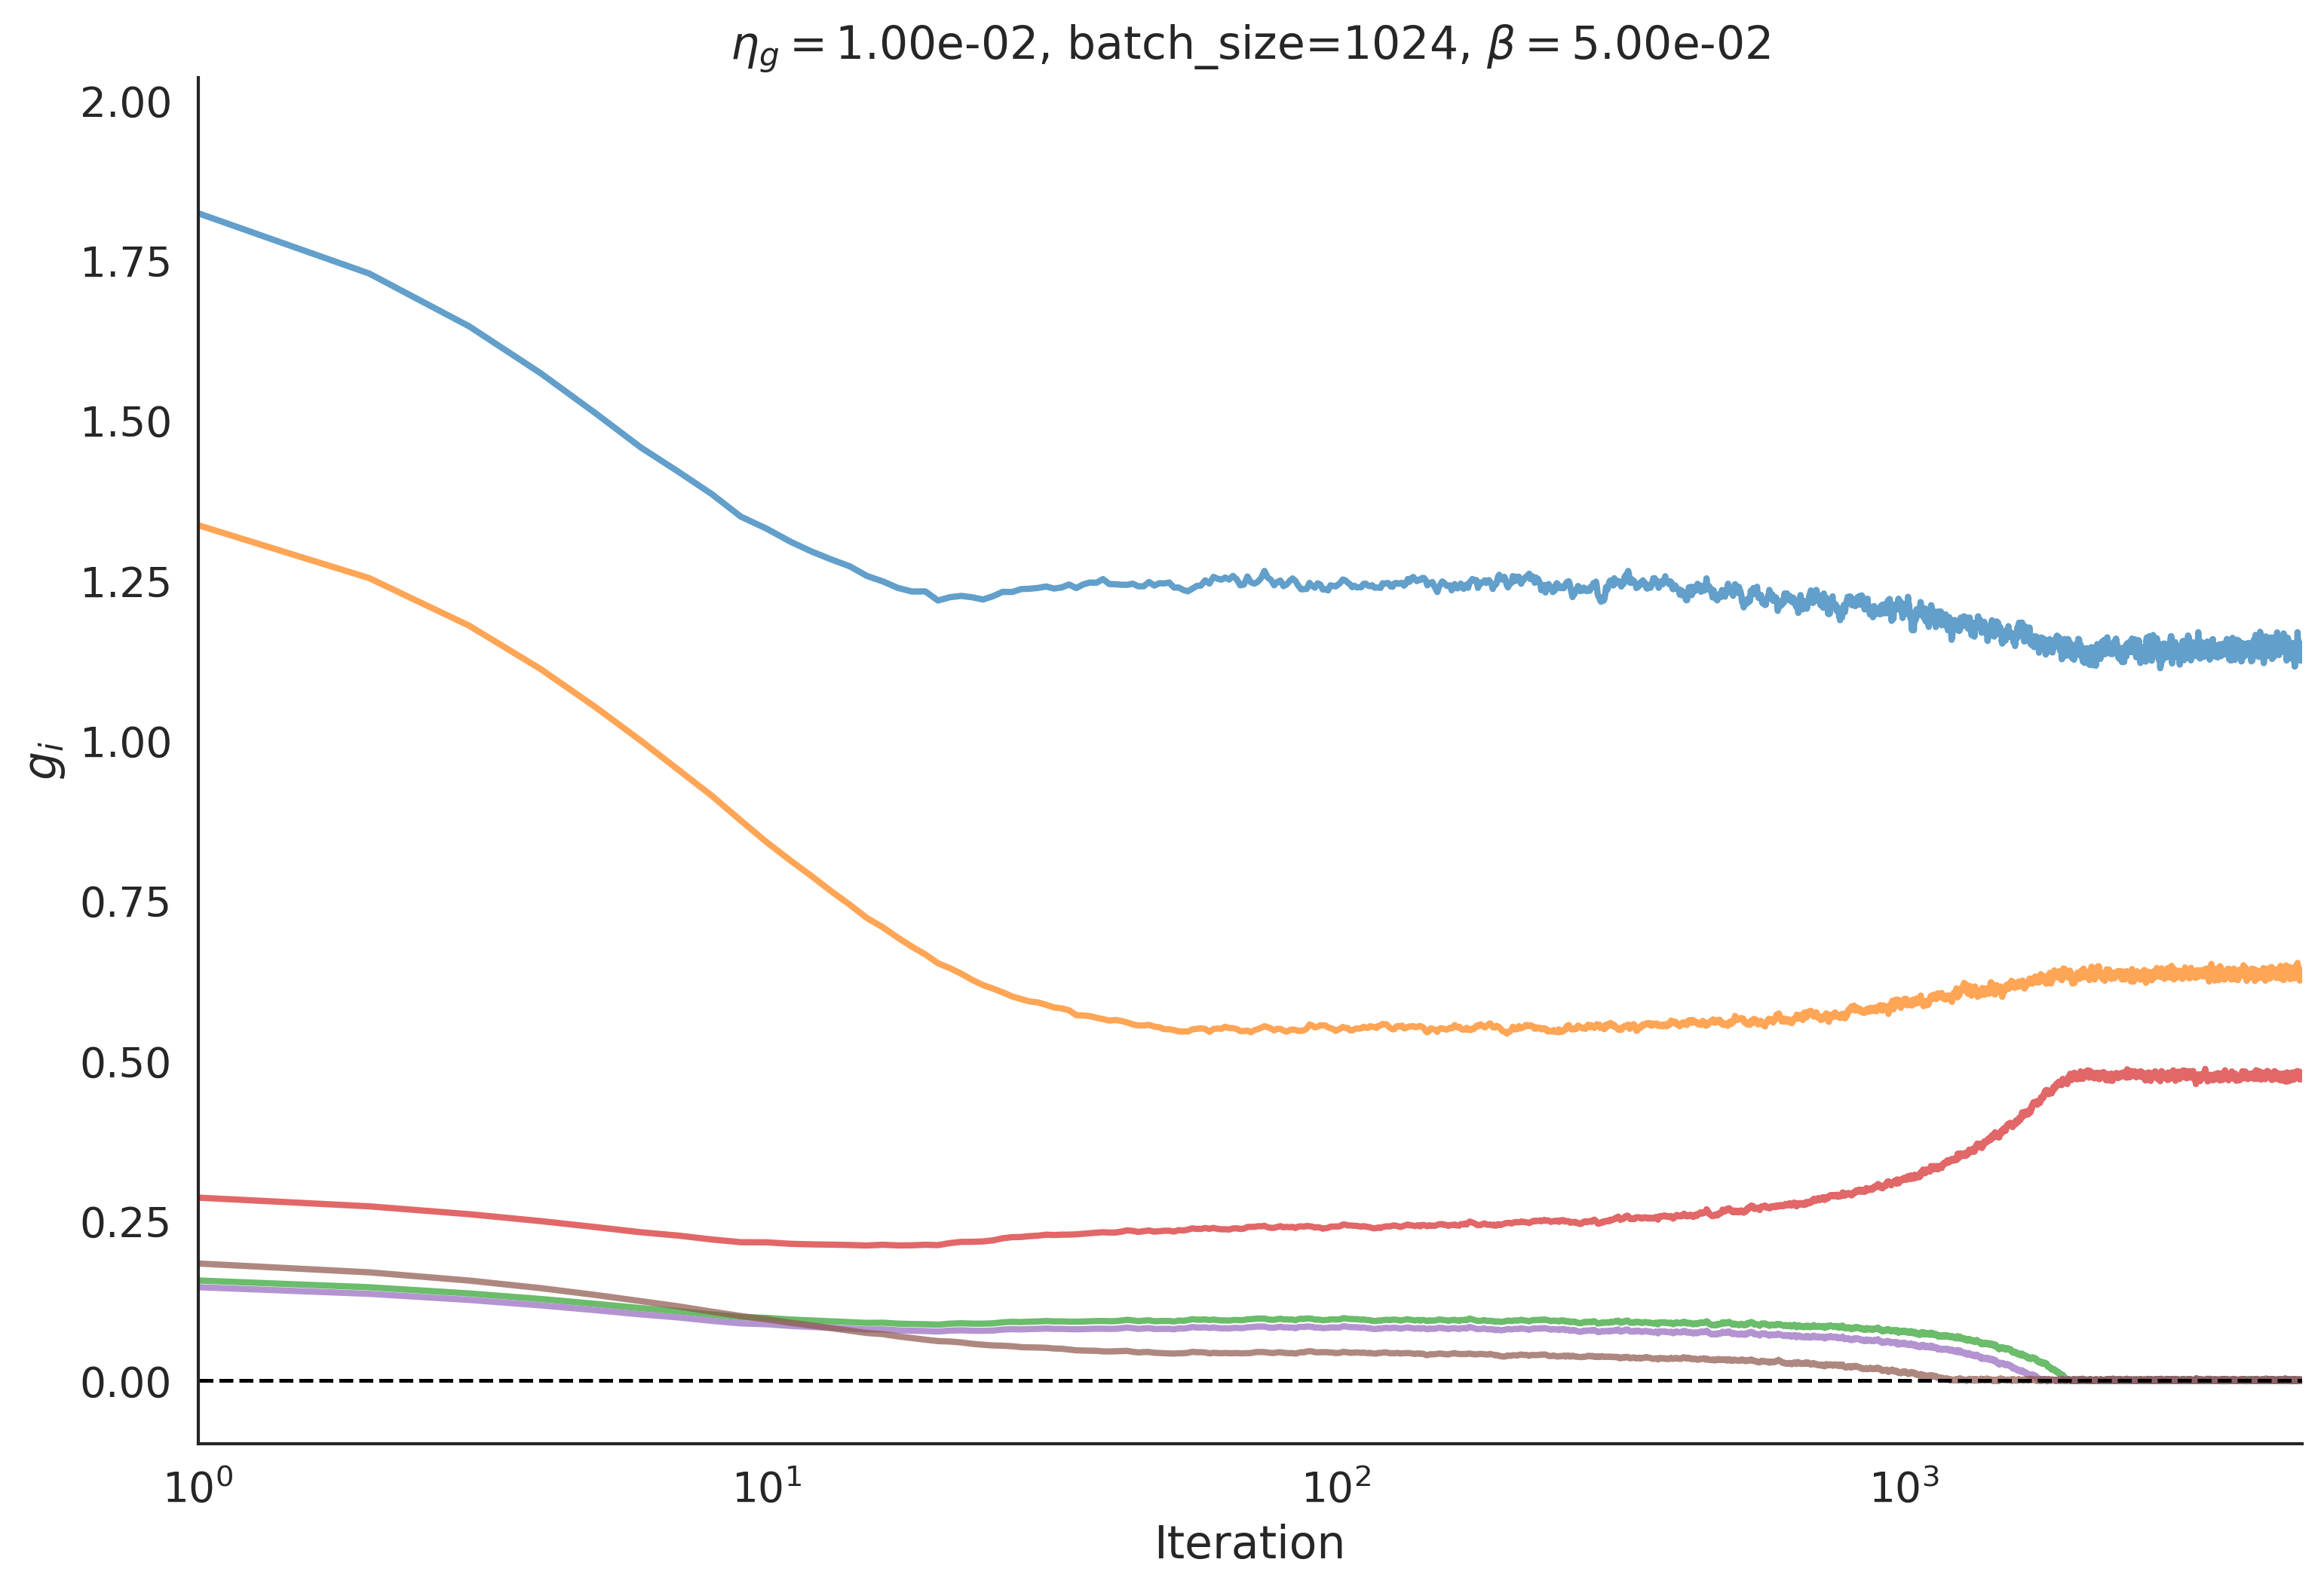

In [5]:
def f(g, func_type, alpha=None):
    if func_type == FuncType.G_EXPONENTIAL:
        return g*np.exp(g)
    elif func_type == FuncType.POWER:
        return np.power(g, alpha+1)
    else:  # FuncType.EXPONENTIAL
        return np.exp(g)

with sns.plotting_context("paper", font_scale=1.5):
    sns.set_style("white")
    fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=300)
    N, K = W.shape

    label = r"${\bf g}^2$"
    ax.plot(f(g_all, func_type, alpha), label=label, linewidth=2, alpha=0.7)
    ax.hlines(0, 0, n_batch, linestyle="--", color="k")

    ax.set(
        xscale="log",
        xlim=(1, n_batch),
        xlabel="Iteration",
        ylabel=r"$g_i$",
        title=f"$\eta_g=${lr_g:.2e}, batch_size={batch_size}, $\\beta=${beta:.2e}",
    )
    sns.despine()

### Plot the covariance before and after

C init
 [[1.59099026 1.23743687]
 [1.23743687 1.59099026]]
C whitened
 [[ 1.00522473 -0.00417234]
 [-0.00417234  1.00430853]]


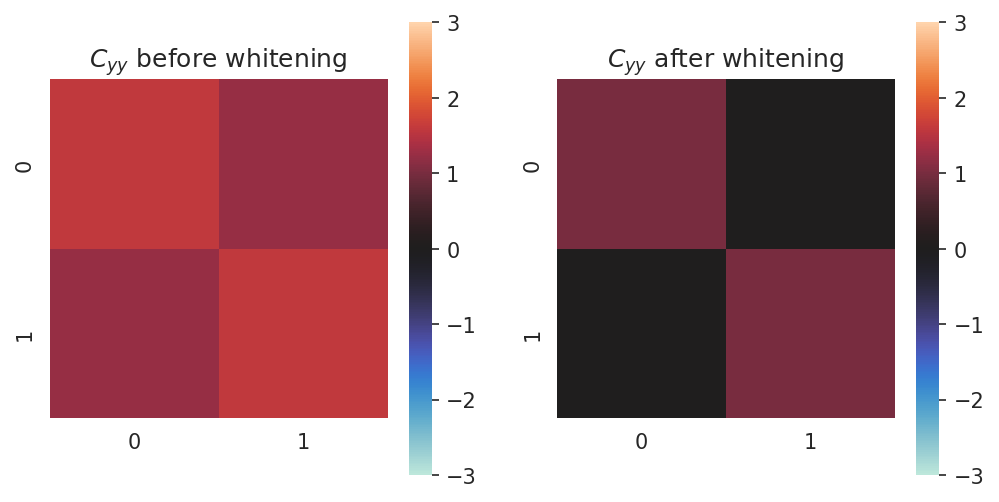

In [6]:
M = np.linalg.inv(W @ np.diag(f(g_last, func_type, alpha)) @ W.T)

print("C init\n", Cxx0)
print("C whitened\n", M @ Cxx0 @ M.T)

def heatmap(C, ax):
    """Helper for plotting covariances."""
    sns.heatmap(C, ax=ax, cmap="icefire", vmin=-3, vmax=3, cbar=True, square=True)

fig, ax = plt.subplots(1,2, figsize=(8,4), dpi=150)
heatmap(Cxx0, ax=ax[0])
heatmap(M@Cxx0@M.T, ax=ax[1])
ax[0].set(title=r"$C_{yy}$ before whitening")
ax[1].set(title=r"$C_{yy}$ after whitening");